In [169]:
#!python -m pip install git+https://github.com/carnotresearch/cr-sparse.git
!python -m pip install git+https://github.com/cda-gti-upm/cr-sparse.git

  Cloning https://github.com/cda-gti-upm/cr-sparse.git to /tmp/pip-req-build-jb_qg__q
  Running command git clone --filter=blob:none --quiet https://github.com/cda-gti-upm/cr-sparse.git /tmp/pip-req-build-jb_qg__q
  Resolved https://github.com/cda-gti-upm/cr-sparse.git to commit 989ebead8a8ac37ade643093e1caa31ae2a3eda1
  Preparing metadata (setup.py) ... done


In [170]:
%matplotlib inline


# Random Orthogonal Measurements, Cosine Basis, ADMM

This example has following features:

* The image being measured is not sparse by itself.
* It does have a sparse representation in discrete cosine basis.
* Measurements are taken by a cosine ensemble ~partial Walsh Hadamard~ sensing matrix
  with small number of orthonormal rows
* The number of measurements is 8 times lower than the dimension of
  the signal space.
* ADMM based Basis pursuit denoising is being used to solve the recovery problem.

This example is adapted from YALL1 package.


Let's import necessary libraries 



In [171]:
import jax.numpy as jnp
from jax import random
norm = jnp.linalg.norm

import matplotlib as mpl
import matplotlib.pyplot as plt

from cr.sparse import lop
from cr.sparse.cvx.adm import yall1
import cr.nimble as cnb
import cr.sparse.dict as crdict

import cv2 as cv 
from skimage import io
import numpy as np

## Setup



In [172]:
key = random.PRNGKey(0)
keys = random.split(key, 4)

## Image: Non-sparse signal



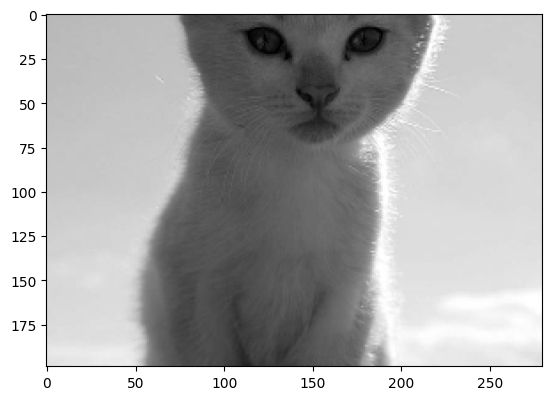

Num pixel: 55720
Num mesurements: 27860


In [173]:
# Read and display the image
urls = ["https://upload.wikimedia.org/wikipedia/commons/2/26/Madrid%2C_Spain_%28satellite_view%29.jpg",
        "https://iiif.lib.ncsu.edu/iiif/0052574/full/800,/0/default.jpg",
        "https://iiif.lib.ncsu.edu/iiif/0016007/full/800,/0/default.jpg",
        "https://placekitten.com/800/571"]  
image = io.imread(urls[3]) 
image_2 = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Resize image
scale_percent = 35 # percent of original size
width = int(image_2.shape[1] * scale_percent / 100)
height = int(image_2.shape[0] * scale_percent / 100)
dim = (width, height)
image_2 = cv.resize(image_2, dim)
plt.imshow(image_2, cmap='gray')
plt.show()

# Flatten image
xs = jnp.array(image_2)/255
xs = xs.flatten()

# Ambient dimension
n = len(xs)
print(f'Num pixel: {n}')
# Number of measurements
porcentage = 50
m = int(n*porcentage/100)
print(f'Num mesurements: {m}')

## The Sparsifying Basis



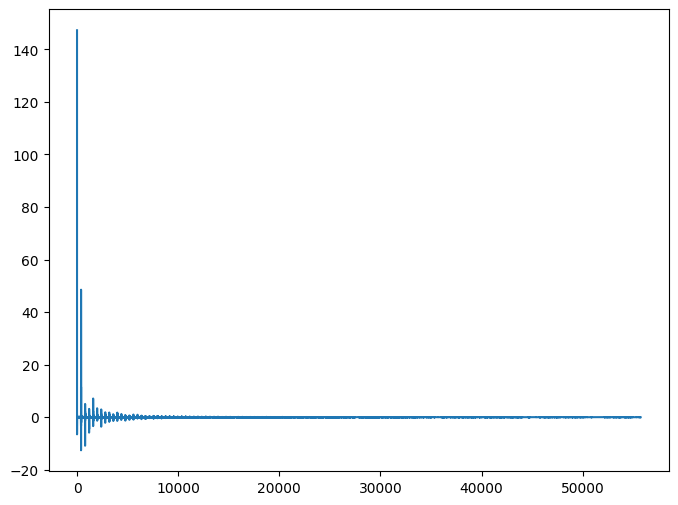

In [174]:
Psi  = lop.jit(lop.cosine_basis(n))
#Psi  = lop.jit(lop.walsh_hadamard_basis(n))

alpha = Psi.trans(xs)
plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(alpha)
plt.show()

## Orthogonal (cosine) ensemble measurement
_Function help_
- [partial_op()](https://carnotresearch.github.io/cr-sparse/_modules/cr/sparse/_src/lop/lop.html): builds a random ensemble from an orthogonal basis



In [175]:
# indices of the measurements to be picked
p = random.permutation(keys[1], n)
picks = jnp.sort(p[:m])
# Make sure that DC component is always picked up
picks = picks.at[0].set(0)
print(f"picks={picks}")

# a random permutation of input
perm = random.permutation(keys[2], n)
print(f"perm={perm}")

# Cosine Basis operator
Twh = lop.cosine_basis(n)

# Wrap it with picks and perm
Tpwh = lop.jit(lop.partial_op(Twh, picks, perm))

picks=[    0     4     7 ... 55716 55718 55719]
perm=[34118 53407  5731 ... 43689 41545 55009]


## Measurement process

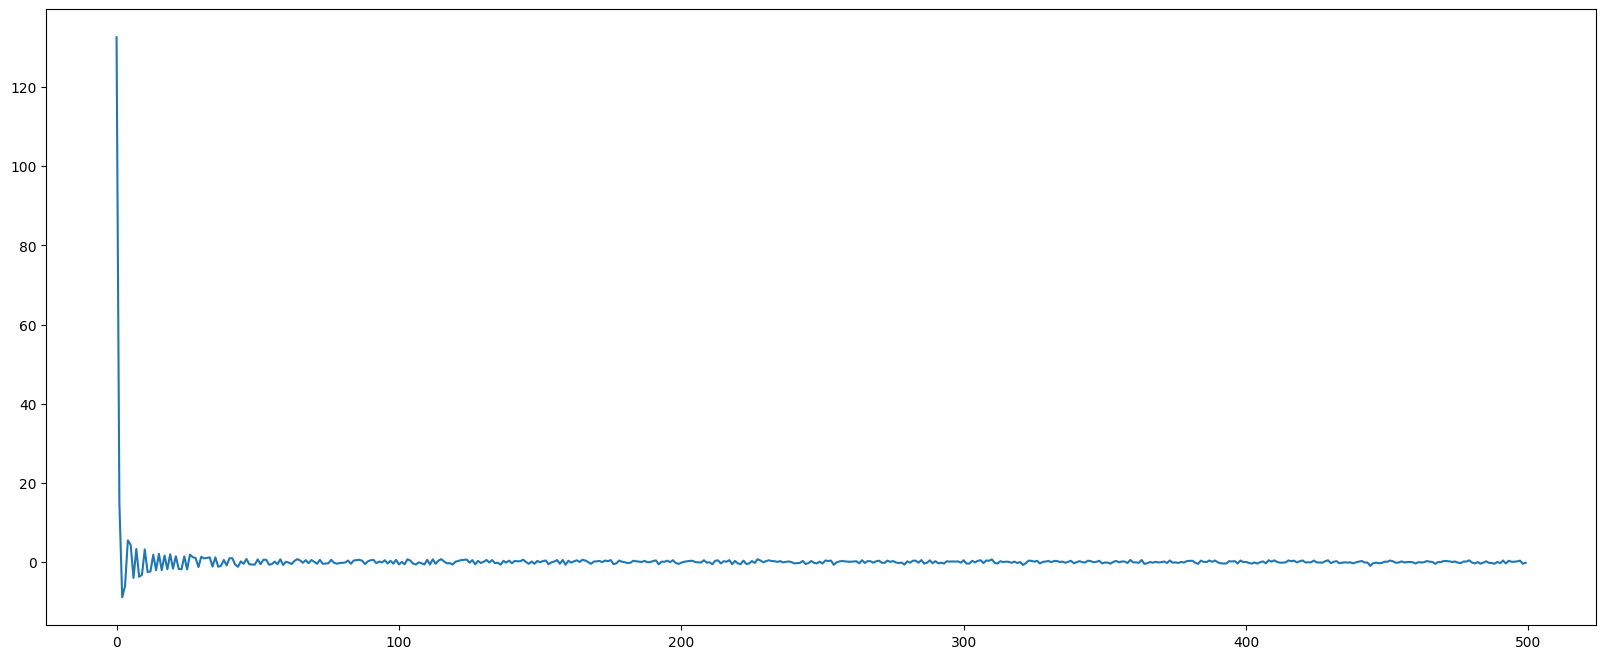

In [176]:
# Perform exact measurement
b = Tpwh.times(xs)

plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(b[:500])
plt.show()

## Recovery using ADMM



In [177]:
# tolerance for solution convergence
tol = 5e-4
# BPDN parameter
rho = 5e-4
# Run the solver
sol = yall1.solve(Tpwh, b, rho=rho, tolerance=tol, W=Psi)
iterations = int(sol.iterations)
#Number of iterations
print(f'iterations={iterations}')
# Relative error
rel_error = norm(sol.x-xs)/norm(xs)
print(f'rel_error={rel_error:.4e}')

iterations=86
rel_error=2.1950e-02


## Solution 



Original image:


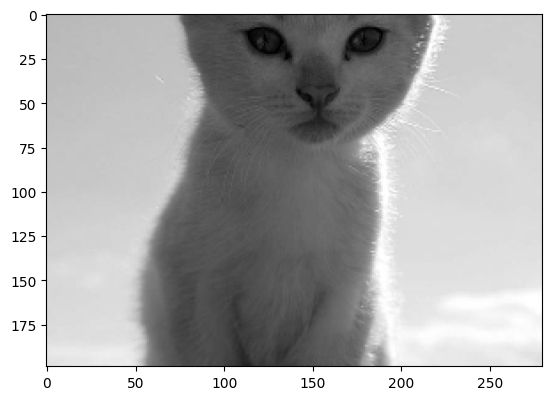

Recovered image:


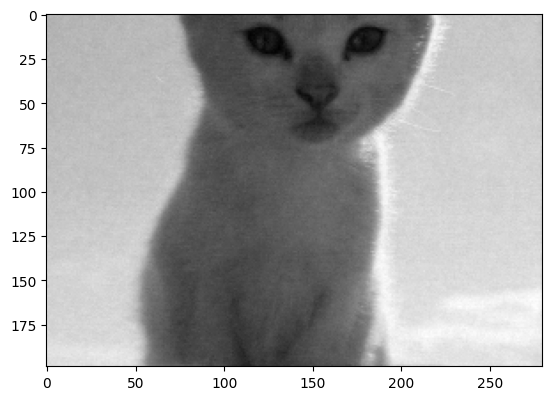

14.216227


In [178]:
# Original image
print("Original image:")
plt.imshow(image_2, cmap='gray')
plt.show()
# Recovered image
im_rec = sol.x.reshape(height, width)*255
print("Recovered image:")
plt.imshow(im_rec, cmap='gray')
plt.show()

# Compute MSE error of recovered image
mse = np.square(np.subtract(image_2, im_rec)).mean()
print(mse)

# Postprocessing
postprocessing_flag = False
if postprocessing_flag:
  im_rec = cv.cvtColor(np.array(im_rec), cv.COLOR_GRAY2RGB)
  # Apply bilateral filter 
  im_rec = cv.bilateralFilter(im_rec, 15, 25, 25)
  plt.imshow(np.array(im_rec) / 255, cmap='gray')
  plt.show()